In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.utils import to_categorical
from nltk.corpus import words
import random as rand

Using TensorFlow backend.


In [2]:
train = pd.read_csv('../input/tweet-sentiment-extraction/train.csv')
test = pd.read_csv('../input/tweet-sentiment-extraction/test.csv')

In [3]:
print("tweet: ",train.text[1])
print("tweet's sentiment: ",train.sentiment[1])
print("selected text that illustrates this sentiment: ",train.selected_text[1])

tweet:   Sooo SAD I will miss you here in San Diego!!!
tweet's sentiment:  negative
selected text that illustrates this sentiment:  Sooo SAD


In [4]:
def refine_text(tweets_list):
    tweets_lower=[item.lower() for item in tweets_list]
    tweets_refined=[item.replace("i`d","i would").replace("you`d","you would").replace("we`d","we would")
                .replace("they`d","they would").replace("he`d","he would").replace("she`d","she would")
                .replace("it`d","it would").replace("i`m","i am").replace("you`re","you are").replace("we`re","we are")
                .replace("they`re","they are").replace("he`s","he is").replace("she`s","she is").replace("it`s","it is")
                .replace("i`ve","i have").replace("you`ve","you have").replace("we`ve","we have")
                .replace("they`ve","they have").replace("i`ll","i will").replace("you`ll","you will")
                .replace("we`ll","we will").replace("they`ll","they will").replace("he`ll","he will")
                .replace("she`ll","she will").replace("it`ll","it will").replace("is`nt","is not")
                .replace("has`nt","has not").replace("don`t","do not").replace("can`t","cannot")
                .replace("aren`t","are not").replace("haven`t","have not").replace("doesn`t","does not")
                .replace("couldn`t","could not").replace("wasn`t","was not").replace("hadn`t","had not")
                .replace("didn`t","did not").replace("won`t","will not") .replace("weren`t","were not")
                .replace("wouldn`t","would not").replace("shouldn`t","should not").replace("mustn`t","must not")
                .replace("needn`t","need not").replace("mightn`t","might not").replace("daren`t","dare not")
                .replace("let`s","let us") for item in tweets_lower]
    return tweets_refined

In [5]:
def preprocess_data(data):
    print("null text:",data.text.isnull().sum())
    if hasattr(data, "selected_text"):
        print("null selected text:",data.selected_text.isnull().sum())
    print("null sentiment:",data.sentiment.isnull().sum())
    print("number of tweets:",len(data))
    
    incorrect_rows=[]
    if hasattr(data, "selected_text"):
        if(data.text.isnull().sum() !=0 or data.selected_text.isnull().sum() !=0 or data.sentiment.isnull().sum() !=0):
            data.dropna(axis=0, how="any", inplace=True)
            data.reset_index(inplace=True)
            print("new number of tweets:",len(data))
        incorrect_selected_Text_counter,incorrect_rows=selected_text_incorrect(data)
        print("incorrect selected text:",incorrect_selected_Text_counter)
        data.drop(incorrect_rows,inplace=True)
        data.reset_index(inplace=True)
    else:
        if(data.text.isnull().sum() !=0 or data.sentiment.isnull().sum() !=0):
            data.dropna(axis=0, how="any", inplace=True)
            data.reset_index(inplace=True)
            print("new number of tweets:",len(data))
            
#    data.text=refine_text(data.text)
    
#    if hasattr(data, "selected_text"):
#        data.selected_text=refine_text(data.selected_text)
    
    return incorrect_rows

In [6]:
def selected_text_incorrect(data):
    incorrect_selected_Text_counter=0
    incorrect_rows=[]
    for i in range(len(data)):
        selected_text_found=False
        selected_text_first_word=data.selected_text[i].split()[0]
        text_list=data.text[i].split()
        first_word_indices=np.where(selected_text_first_word == np.array(text_list))
            
        for j in first_word_indices[0]:
            selected=None
            start_index=j
            end_index=j+len(data.selected_text[i].split())-1
            selected_correct=data.text[i].split()[start_index:end_index+1]
            input_selected_split=data.selected_text[i].split()
            
            if np.array_equal(np.array(input_selected_split),np.array(selected_correct)):
                selected_text_found=True
                break  
                
        if (not selected_text_found):
            incorrect_rows.append(i)
            incorrect_selected_Text_counter+=1
    
    return incorrect_selected_Text_counter,incorrect_rows

In [7]:
incorrect_selected_text=preprocess_data(train)
preprocess_data(test)

text_sentiment_train=[(train.text[i]+" "+train.sentiment[i]) for i in range(len(train))]
text_sentiment_test=[(test.text[i]+" "+test.sentiment[i]) for i in range(len(test))]

null text: 1
null selected text: 1
null sentiment: 0
number of tweets: 27481
new number of tweets: 27480
incorrect selected text: 2931
null text: 0
null sentiment: 0
number of tweets: 3534


In [8]:
print(incorrect_selected_text)

[2, 18, 27, 32, 39, 48, 49, 60, 64, 66, 84, 86, 92, 102, 116, 129, 132, 134, 149, 160, 166, 168, 189, 196, 197, 204, 210, 223, 240, 247, 251, 260, 285, 295, 296, 297, 309, 315, 342, 348, 361, 365, 381, 395, 397, 405, 409, 424, 457, 481, 491, 497, 499, 503, 512, 516, 532, 536, 541, 542, 568, 572, 580, 603, 604, 607, 635, 636, 638, 641, 664, 669, 673, 677, 684, 701, 706, 708, 709, 726, 736, 745, 750, 756, 767, 777, 786, 793, 803, 808, 845, 852, 853, 855, 862, 865, 870, 871, 899, 911, 930, 936, 941, 949, 955, 956, 962, 991, 992, 998, 1000, 1010, 1011, 1035, 1038, 1056, 1059, 1061, 1071, 1072, 1075, 1076, 1082, 1095, 1104, 1115, 1116, 1121, 1133, 1136, 1149, 1156, 1158, 1180, 1191, 1198, 1199, 1208, 1216, 1244, 1263, 1270, 1279, 1282, 1297, 1299, 1302, 1318, 1326, 1341, 1359, 1362, 1364, 1371, 1373, 1375, 1381, 1392, 1405, 1415, 1416, 1419, 1446, 1453, 1467, 1471, 1512, 1514, 1517, 1530, 1547, 1557, 1566, 1579, 1587, 1599, 1604, 1622, 1647, 1648, 1656, 1658, 1660, 1664, 1670, 1671, 1672, 1

In [9]:
text_sentiment_train[1]

' Sooo SAD I will miss you here in San Diego!!! negative'

In [10]:
max_word_dict = len(words.words())
my_dictionary=rand.sample(words.words(),max_word_dict)

tokenizer = Tokenizer(num_words=max_word_dict, lower=True, oov_token="<UKN>",filters='\t\n')
tokenizer.fit_on_texts(list(my_dictionary))
tokenized_tweets_train = tokenizer.texts_to_sequences(text_sentiment_train)
tokenized_tweets_test = tokenizer.texts_to_sequences(text_sentiment_test)
tokenized_selected_text_train = tokenizer.texts_to_sequences(train.selected_text)

#tokenizer.word_counts
#tokenizer.word_index

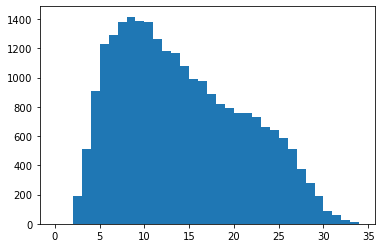

In [11]:
totalNumWords = [len(one_tweet) for one_tweet in tokenized_tweets_train]
plt.hist(totalNumWords,bins = np.arange(0,35,1))
plt.show()

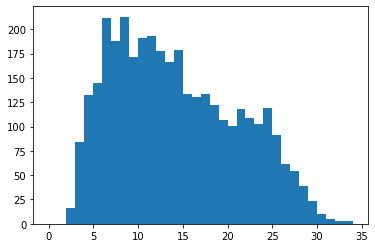

In [12]:
totalNumWords_test = [len(one_tweet) for one_tweet in tokenized_tweets_test]
plt.hist(totalNumWords_test,bins = np.arange(0,35,1))
plt.show()

In [13]:
max_tweet_length = 36
x_train = pad_sequences(tokenized_tweets_train, maxlen=max_tweet_length)
x_test = pad_sequences(tokenized_tweets_test, maxlen=max_tweet_length)

In [14]:
y_train=[]
for i in range(len(x_train)):
    selected_text_array=np.array(tokenized_selected_text_train[i])
    first_word_indices=np.where(x_train[i]==selected_text_array[0])
    first_word_indices=np.array(first_word_indices)
    for j in first_word_indices[0]:
        start_index=j
        end_index=j+np.max(np.shape(selected_text_array))-1
        x_train_sub_array=x_train[i][start_index:end_index+1]
        if np.array_equal(x_train_sub_array,selected_text_array):
            break
    selected_text=np.zeros(max_tweet_length)
    selected_text[start_index:end_index+1]=1
    y_train.append(selected_text)
y_train=np.array(y_train)    

In [15]:
def get_selected_text(x,y,data_text,tokenizer):
    incorrect_selected_text=[]
    selected_text_output=[]
    all_selected=[]
    reverse_tokenizer=dict(map(reversed,tokenizer.word_index.items()))
    data_text_lower=[item.lower() for item in data_text]
    for i in range(len(data_text)):
        found_correct_selected=False
        sentiment_indices=np.where(y[i]==1)
        if len(sentiment_indices[0])==0:
            incorrect_selected_text.append(i)
            all_selected.append("<<<empty prediction>>>")
            continue    
            
        #print(i)    
            
        start_index=sentiment_indices[0][0]
        end_index=sentiment_indices[0][-1]
        selected_text_tokens=x[i][start_index:end_index+1]
        selected_text_words=[reverse_tokenizer.get(index) for index in selected_text_tokens]
        
        has_none=False
        for word in selected_text_words:
            if word is None:
                has_none=True
                break              
        if has_none==True:
            incorrect_selected_text.append(i)
            all_selected.append("<<<prediction has none>>")
            continue   
                        
        all_selected.append(" ".join(selected_text_words))
        
        first_word_indices=np.where(selected_text_words[0]==np.array(data_text_lower[i].split()))
        for j in first_word_indices[0]:
            start_index=j
            end_index=j+len(selected_text_words)-1
            selected_trial=data_text_lower[i].split()[start_index:end_index+1]
            
            if np.array_equal(np.array(selected_trial),np.array(selected_text_words)):
                found_correct_selected=True
                correct_selected_text=data_text[i].split()[start_index:end_index+1]
                correct_selected_text=" ".join(correct_selected_text)
                selected_text_output.append(correct_selected_text)
                break
                
        if not found_correct_selected:
            incorrect_selected_text.append(i)
    print("incorrect selected text:",len(incorrect_selected_text))
    return selected_text_output,incorrect_selected_text, all_selected

In [16]:
y_correct,y_incorrect_indices,y_all=get_selected_text(x_train,y_train,train.text,tokenizer)

incorrect selected text: 17974


In [17]:
embed_size = 128
inp = Input(shape=(max_tweet_length,)) #max_tweet_length=36
x = Embedding(max_word_dict, embed_size)(inp)
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(max_tweet_length, activation="sigmoid")(x)

model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 36)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 36, 128)           30302208  
_________________________________________________________________
lstm_layer (LSTM)            (None, 36, 60)            45360     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0   

In [18]:
batch_size = 32
epochs = 2
## the inputs to the method fit() have to be arrays not lists
model.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 22094 samples, validate on 2455 samples
Epoch 1/2
22094/22094 [==============================] - 355s 16ms/step - loss: 0.2552 - accuracy: 0.8847 - val_loss: 0.1589 - val_accuracy: 0.9353
Epoch 2/2
22094/22094 [==============================] - 356s 16ms/step - loss: 0.1609 - accuracy: 0.9304 - val_loss: 0.1489 - val_accuracy: 0.9343


In [19]:
y_test=model.predict(x_test)
y_test=np.around(y_test)

In [20]:
y_test_correct,y_test_incorrect_indices,y_test_all=get_selected_text(x_test,y_test,test.text,tokenizer)

incorrect selected text: 3148


In [21]:
test_data={"textID":test.textID,
           "text":test.text,
           "selected_text":y_test_all,
           "sentiment":test.sentiment
}
test_csv=pd.DataFrame(test_data,columns=["textID","text","selected_text","sentiment"])
test_csv.to_csv('trial.csv',index=False)

In [22]:
submission_data={"textID":test.textID,
           "selected_text":y_test_all,
}
test_csv=pd.DataFrame(submission_data,columns=["textID","selected_text"])
test_csv.to_csv('submission.csv',index=False)